---

# Lib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MultiLabelBinarizer

from utils.other import parse_label

---

# Read file

In [3]:
df = pd.read_csv("../data/raw/train.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [4]:
df.head()

,brand,model,version,year,segment,comment,label
0,honda,hr-v,g,2025,suv,HRV-G xài máy 1.8+ thì hay quá thế hệ máy SOHC...,{PERFORMANCE#Positive};
1,toyota,vios,NaN,2025,sedan,"Vios đi ngon mà, mình đi thấy rất khỏe nh...",{PERFORMANCE#Positive};{INTERIOR#Negative};
2,skoda,kushaq,style,2025,suv,Đẹp .,{EXTERIOR#Positive};
3,byd,sealion 6,NaN,2025,suv,Phải công nhận hãng xe tq họ làm đẹp thật. Khó...,{BRAND#Positive};{EXTERIOR#Positive};
4,omoda,c5,NaN,2024,suv,"Giá tốt, trang bị tốt, an toàn tiêu chuẩn. Qua...",{FEATURES#Positive};{COST#Positive};{BRAND#Neu...


---

# EDA

In [5]:
print(f"{df.shape[0]} rows")
print(f"{df.shape[1]} columns")

2599 rows
7 columns


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2599 entries, 0 to 2598
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    2599 non-null   object
 1   model    2599 non-null   object
 2   version  1711 non-null   object
 3   year     2599 non-null   int64 
 4   segment  2599 non-null   object
 5   comment  2599 non-null   object
 6   label    2599 non-null   object
dtypes: int64(1), object(6)
memory usage: 142.3+ KB


## Missing values

Sự null này là MNAR (Missing not a random) tức version được thiếu vì:
- video, người đánh giá không đề cập rõ về version cụ thể của xe mà đánh giá chung về model xe đó hoặc các loại xe.
- Không quá khác biệt về thiết kế nột thất hoặc ngoại thất mà có thể là sự khác biệt về động cơ hoặc các tính năng, công nghệ được trang bị.
- Xe chỉ có duy nhất 1 version được bán ra thị trường với tên brand + model

In [7]:
df.isnull().sum()

brand        0
model        0
version    888
year         0
segment      0
comment      0
label        0
dtype: int64

## Categorical columns

In [8]:
for col in df.columns[:-2]:
    num_unique_values = df[col].nunique()
    print(f"{col}: {num_unique_values} unique values")

brand: 13 unique values
model: 21 unique values
version: 18 unique values
year: 2 unique values
segment: 2 unique values


In [9]:
for col in df.columns[:-2]:
    print(f"{col}: {df[col].unique()}")
    print()

brand: ['honda' 'toyota' 'skoda' 'byd' 'omoda' 'nissan' 'mazda' 'geely' 'mg'
 'mitsubishi' 'huyndai' 'kia' 'hyundai']

model: ['hr-v' 'vios' 'kushaq' 'sealion 6' 'c5' 'almera' '2' 'coolray' 'slavia'
 'kicks' 'zs' 'attrage' 'accent' 'atto 3' 'atto 2' 'xforce' 'seltos'
 'yaris cross' 'creta' 'seal 5' 'soluto']

version: ['g' nan 'style' 'at' 'flagship' 'e-powers' 'luxury' 'cvt' 'ultimate'
 'facelift' 'hybrid' 'std' 'máy xăng' 'active' 'ambiton' 'n line' 'dm-i'
 'l' 'e']

year: [2025 2024]

segment: ['suv' 'sedan']



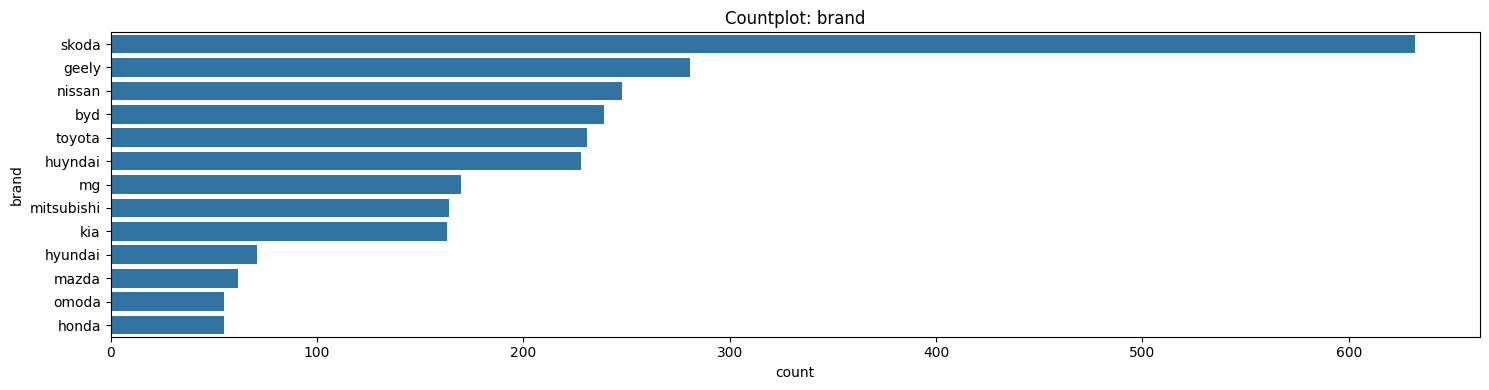

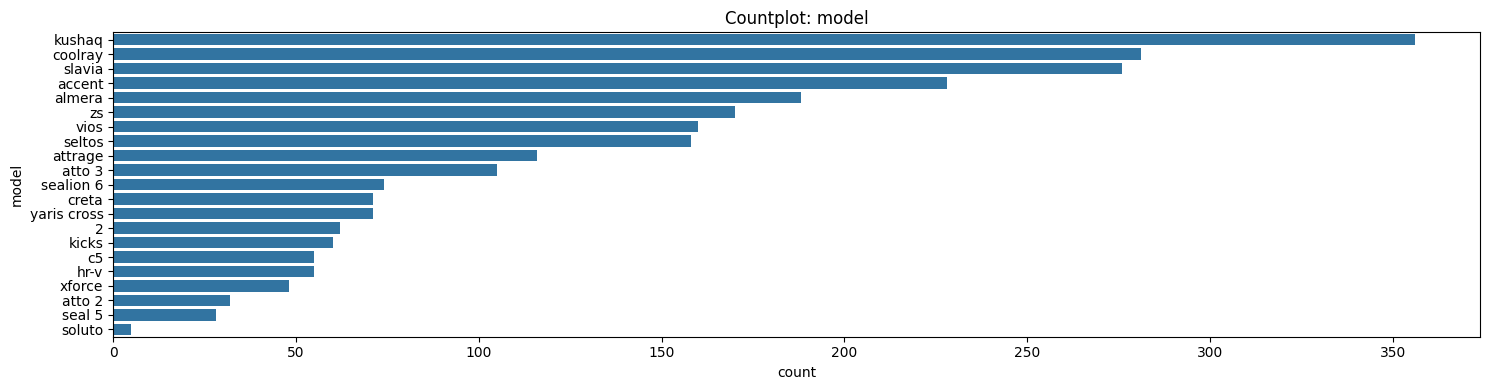

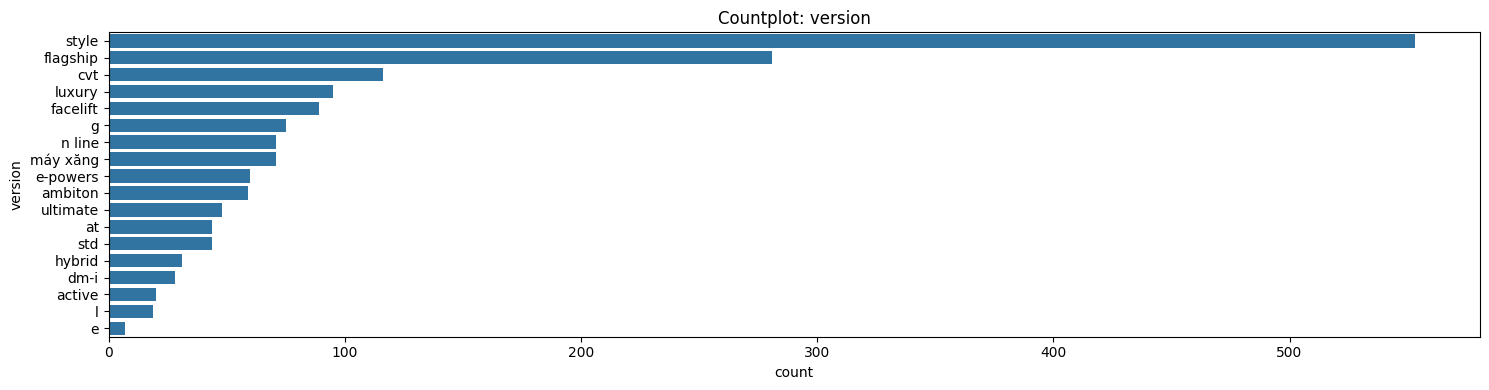

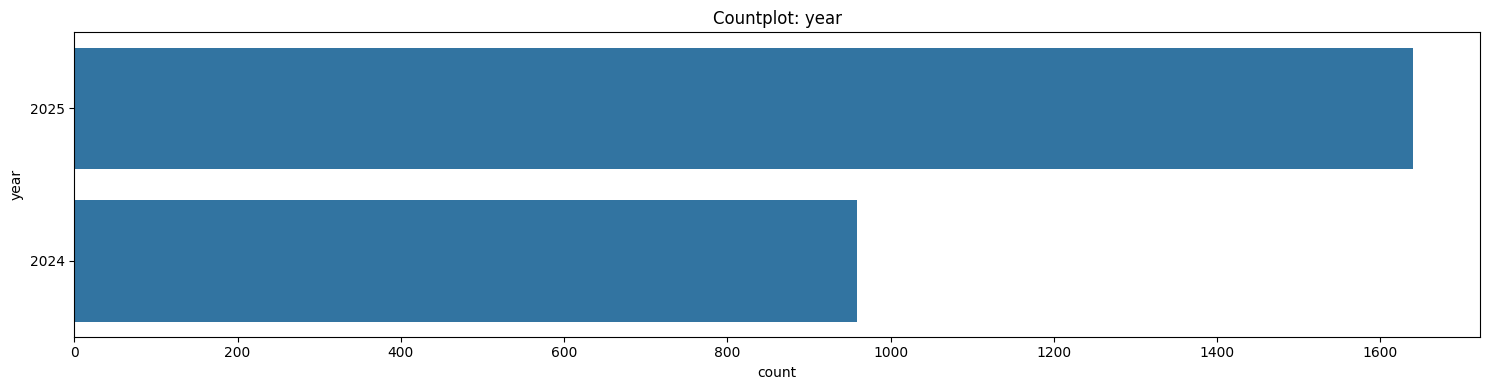

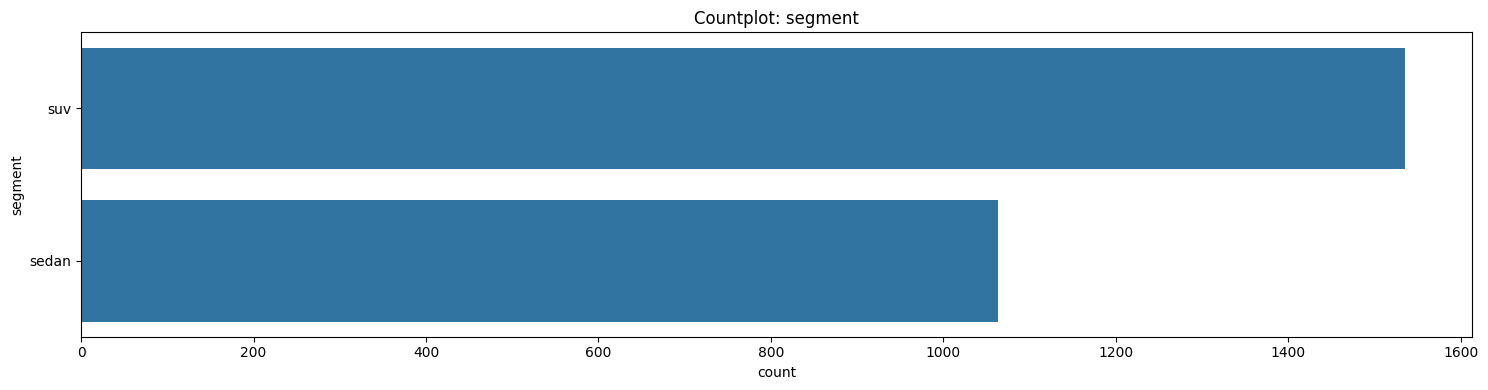

In [10]:
for col in df.columns[:-2]:
    counts = df[col].value_counts()
    plt.figure(figsize=(15, 4))
    sns.countplot(y=col, data=df, order=counts.index)
    plt.title(f"Countplot: {col}")
    plt.tight_layout()
    plt.show()

---

# Labels

In [11]:
df_label = df[["comment", "label"]].copy()

In [12]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2599 entries, 0 to 2598
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  2599 non-null   object
 1   label    2599 non-null   object
dtypes: object(2)
memory usage: 40.7+ KB


In [13]:
df_label.head()

,comment,label
0,HRV-G xài máy 1.8+ thì hay quá thế hệ máy SOHC...,{PERFORMANCE#Positive};
1,"Vios đi ngon mà, mình đi thấy rất khỏe nh...",{PERFORMANCE#Positive};{INTERIOR#Negative};
2,Đẹp .,{EXTERIOR#Positive};
3,Phải công nhận hãng xe tq họ làm đẹp thật. Khó...,{BRAND#Positive};{EXTERIOR#Positive};
4,"Giá tốt, trang bị tốt, an toàn tiêu chuẩn. Qua...",{FEATURES#Positive};{COST#Positive};{BRAND#Neu...


## Parsed label

In [14]:
df_label["parsed_labels"] = df_label["label"].apply(parse_label)

In [15]:
print(df_label['parsed_labels'].head())
print()
print(df_label['parsed_labels'].iloc[0])

0                               [PERFORMANCE#Positive]
1            [PERFORMANCE#Positive, INTERIOR#Negative]
2                                  [EXTERIOR#Positive]
3                  [BRAND#Positive, EXTERIOR#Positive]
4    [FEATURES#Positive, COST#Positive, BRAND#Neutral]
Name: parsed_labels, dtype: object

['PERFORMANCE#Positive']


## Create binary matrix for multi-label classification

In [16]:
# Use MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [17]:
# Binary matrix for multi-label classification
matrix_label = mlb.fit_transform(df_label['parsed_labels'])

In [18]:
y = pd.DataFrame(matrix_label, columns=mlb.classes_)
y.head()

,BRAND#Negative,BRAND#Neutral,BRAND#Positive,COST#Negative,COST#Neutral,COST#Positive,EXTERIOR#Negative,EXTERIOR#Neutral,EXTERIOR#Positive,FEATURES#Negative,FEATURES#Neutral,FEATURES#Positive,INTERIOR#Negative,INTERIOR#Neutral,INTERIOR#Positive,PERFORMANCE#Negative,PERFORMANCE#Neutral,PERFORMANCE#Positive
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [19]:
label_counts = y.sum(axis=0).sort_values(ascending=False)
total_labels = int(y.values.sum())

In [20]:
print(f"Total labels: {total_labels}")

Total labels: 3732


In [21]:
print(f"Unique labels: {mlb.classes_}")

Unique labels: ['BRAND#Negative' 'BRAND#Neutral' 'BRAND#Positive' 'COST#Negative'
 'COST#Neutral' 'COST#Positive' 'EXTERIOR#Negative' 'EXTERIOR#Neutral'
 'EXTERIOR#Positive' 'FEATURES#Negative' 'FEATURES#Neutral'
 'FEATURES#Positive' 'INTERIOR#Negative' 'INTERIOR#Neutral'
 'INTERIOR#Positive' 'PERFORMANCE#Negative' 'PERFORMANCE#Neutral'
 'PERFORMANCE#Positive']


In [22]:
label_counts

EXTERIOR#Positive       428
BRAND#Positive          393
COST#Positive           392
PERFORMANCE#Positive    390
COST#Negative           291
BRAND#Negative          278
INTERIOR#Positive       269
FEATURES#Positive       248
EXTERIOR#Negative       247
FEATURES#Negative       206
PERFORMANCE#Negative    204
INTERIOR#Negative       143
EXTERIOR#Neutral         56
BRAND#Neutral            51
PERFORMANCE#Neutral      41
FEATURES#Neutral         39
COST#Neutral             38
INTERIOR#Neutral         18
dtype: int64

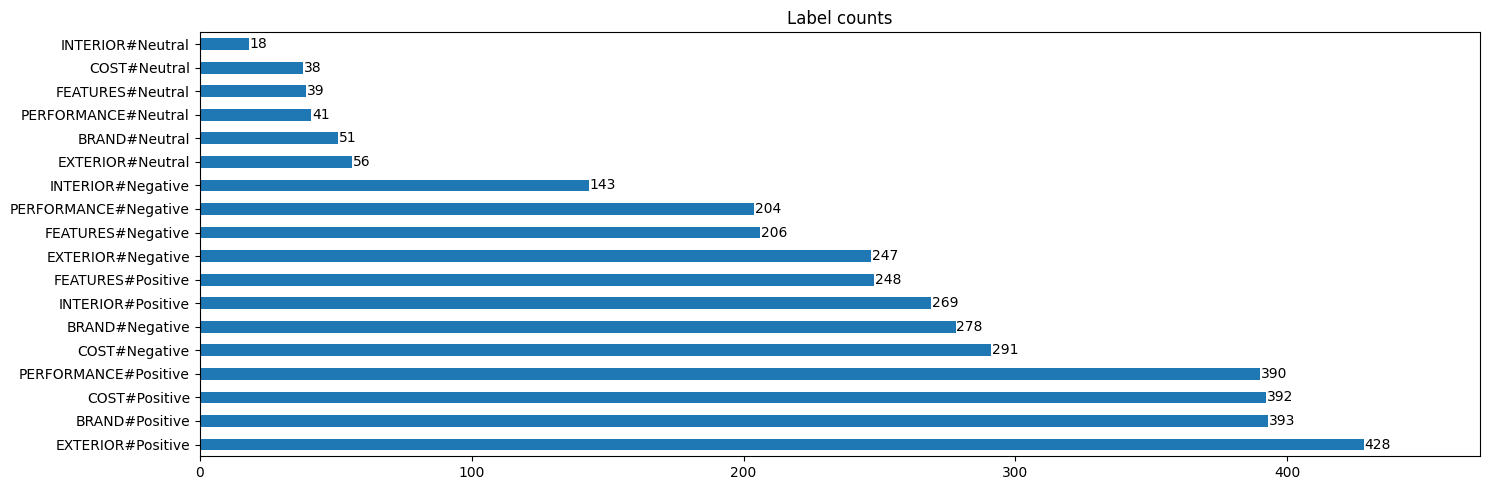

In [23]:
ax = label_counts.plot(kind='barh', figsize=(15,5), title='Label counts')
max_width = int(label_counts.max())
for p in ax.patches:
    value = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    x = p.get_x() + p.get_width() + 0.3
    ax.text(x, y, str(value), va='center', ha='left', fontsize=10)
ax.set_xlim(0, max_width * 1.10) 
plt.tight_layout()
plt.show()